In [178]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import s3fs
from functools import reduce

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
%matplotlib inline


In [237]:
#Extra functions helpers
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [180]:
fs = s3fs.S3FileSystem()
files = fs.glob('pg-ml-repository/last_bid_spark_shuffled.csv/*.csv')

readDf = lambda file : pd.read_csv('s3://' + file)
appendDf = lambda acc, df : acc.append(df)


df = reduce(appendDf, map(readDf, files))
                            
df.head()


carrier_code departure_time fare_class  flight_number  partner_id origin  \
0           AC          21:40          N            876         179    YYZ   
1           AC          15:35          K            717         179    LGA   
2           AC          09:00          L             34         179    YVR   
3           AC          12:55          K           1925         179    LGW   
4           AC          17:25          W            874         179    YUL   

  destination currency  pax    channel_source  total_fare_paid  \
0         FRA      CAD    1    MARKETING_PAGE              NaN   
1         YYZ      EUR    2    MARKETING_PAGE              NaN   
2         YYZ      CAD    1  PRE_TRAVEL_EMAIL              NaN   
3         YYZ      CAD    2    MARKETING_PAGE              NaN   
4         FRA      CAD    2    MARKETING_PAGE              NaN   

  total_fare_paid_currency   device  ppp_enabled  slider_max_usd  \
0                      CAD  desktop        False       1095.3427   
1                      EUR  desktop        False        486.8520   
2                      NaN   mobile        False             NaN   
3                      CAD  desktop        False        611.8638   
4                      CAD  desktop        False       1441.1759   

   slider_min_usd  slider_start_usd  has_bid  
0        631.6210          767.5394    False  
1        130.6188          213.7399    False  
2             NaN               NaN    False  
3        246.3347          337.7170    False  
4        760.6206          960.7839    False

In [181]:
#What is the distribution of numerical feature values across the samples?
df.describe()

flight_number  partner_id            pax  total_fare_paid  \
count  680804.000000    680804.0  680804.000000        83.000000   
mean     2342.637295       179.0       1.549583       982.058434   
std      3135.773877         0.0       0.846415       671.899840   
min         1.000000       179.0       1.000000       139.000000   
25%       271.000000       179.0       1.000000       510.000000   
50%       846.000000       179.0       1.000000       779.000000   
75%      1918.000000       179.0       2.000000      1312.000000   
max      9992.000000       179.0       9.000000      2522.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  
count   489513.000000   489513.000000     489513.000000  
mean       863.075325      391.664828        522.370217  
std        476.770360      277.866313        330.346686  
min         16.549400        0.000000          4.964800  
25%        483.968900      165.000000        250.697500  
50%        731.763300      315.391900        450.000000  
75%       1233.506900      599.527400        764.496000  
max      11391.229900     5796.364700       7218.810800

In [182]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

carrier_code departure_time fare_class  origin destination currency  \
count        680804         680186     680804  680804      680804   680804   
unique          175            919         26     840         872       12   
top              AC          20:55          K     YYZ         YYZ      CAD   
freq         646376          12173     175541  182669      182448   516611   

        channel_source total_fare_paid_currency   device  
count           680804                   514692   680804  
unique               4                       12        2  
top     MARKETING_PAGE                      CAD  desktop  
freq            361555                   380856   514692

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680804 entries, 0 to 3682
Data columns (total 18 columns):
carrier_code                680804 non-null object
departure_time              680186 non-null object
fare_class                  680804 non-null object
flight_number               680804 non-null int64
partner_id                  680804 non-null int64
origin                      680804 non-null object
destination                 680804 non-null object
currency                    680804 non-null object
pax                         680804 non-null int64
channel_source              680804 non-null object
total_fare_paid             83 non-null float64
total_fare_paid_currency    514692 non-null object
device                      680804 non-null object
ppp_enabled                 680804 non-null bool
slider_max_usd              489513 non-null float64
slider_min_usd              489513 non-null float64
slider_start_usd            489513 non-null float64
has_bid                     6

## Conclusions about the original data

1) total_fare_paid should be discarded because theres not enough data.

2) there are lots of missing data on sliders, should we fill it with a random between average and std ?

3) we should vectorize the features or turn them into binary features using get_dummies.

...


## Numerical analysis

In [184]:
df["partner_id"].value_counts()

179    680804
Name: partner_id, dtype: int64

In [185]:
df["ppp_enabled"].value_counts()

False    680804
Name: ppp_enabled, dtype: int64

In [250]:
df[['fare_class', 'has_bid']].groupby(['fare_class'], as_index=False).mean().sort_values(by='has_bid', ascending=False)

fare_class   has_bid
4           E  0.103531
13          N  0.084529
14          O  0.069415
6           G  0.055366
21          V  0.053277
22          W  0.048322
20          U  0.046798
12          M  0.043588
7           H  0.042747
24          Y  0.042230
5           F  0.040359
18          S  0.039445
16          Q  0.039010
19          T  0.036857
11          L  0.032828
23          X  0.031530
0           A  0.030024
10          K  0.025088
1           B  0.023102
17          R  0.000000
15          P  0.000000
9           J  0.000000
8           I  0.000000
3           D  0.000000
2           C  0.000000
25          Z  0.000000

In [187]:
print(df["channel_source"].value_counts())
df[['channel_source', 'has_bid']].groupby(['channel_source'], as_index=False).mean().sort_values(by='has_bid', ascending=False)

MARKETING_PAGE                              361555
PRE_TRAVEL_EMAIL                            318574
MARKETING_PAGE+DETAILS_RESUBMIT_BUTTON         572
PRE_TRAVEL_EMAIL+DETAILS_RESUBMIT_BUTTON       103
Name: channel_source, dtype: int64


channel_source   has_bid
3  PRE_TRAVEL_EMAIL+DETAILS_RESUBMIT_BUTTON  0.689320
1    MARKETING_PAGE+DETAILS_RESUBMIT_BUTTON  0.505245
0                            MARKETING_PAGE  0.045000
2                          PRE_TRAVEL_EMAIL  0.025853

In [246]:
df[['currency', 'has_bid']].groupby(['currency'], as_index=False).mean().sort_values(by='has_bid', ascending=False)

currency   has_bid
2       CHF  0.054393
6       HKD  0.047452
7       JPY  0.045455
11      USD  0.040723
1       CAD  0.036308
5       GBP  0.034789
3       DKK  0.030327
0       AUD  0.026574
4       EUR  0.024270
8       NOK  0.023184
9       SEK  0.022826
10      TWD  0.002670

In [189]:

df[['device', 'has_bid']].groupby(['device'], as_index=False).mean().sort_values(by='has_bid', ascending=False)

device   has_bid
0  desktop  0.036746
1   mobile  0.035837

## Visualization analysis

In [190]:
plot_distribution( df , var = 'slider_start_usd' , target = 'has_bid' )

In [191]:
plot_distribution( df , var = 'slider_max_usd' , target = 'has_bid' )

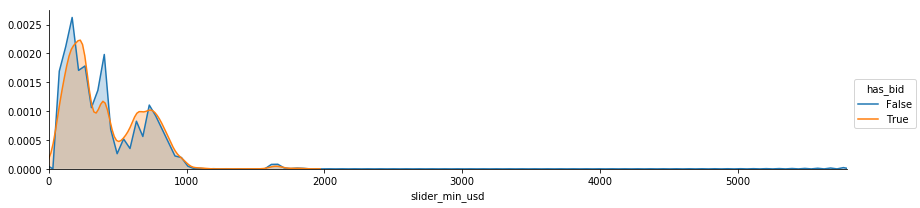

In [192]:
plot_distribution( df , var = 'slider_min_usd' , target = 'has_bid' )

In [244]:
plot_categories( df, size=3, aspect=1 , cat = 'device' , target = 'has_bid' )

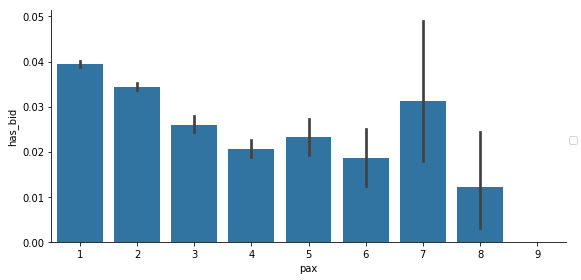

In [228]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

## Wrangle Data

### Removing features

In [195]:
train_df = df.drop(["total_fare_paid", "total_fare_paid_currency", "ppp_enabled", "partner_id", "flight_number", "carrier_code"], axis = 1)

### Fill or Drop Nans 

In [196]:
#just as example, we could fill nans like this, or we can fill it with a random value between mean and std
#df[ 'slider_start_usd' ] = df.slider_start_usd.fillna( df.slider_start_usd.mean() )
#df[ 'slider_min_usd' ] = df.slider_min_usd.fillna( df.slider_min_usd.mean() )
#df[ 'slider_max_usd' ] = df.slider_max_usd.fillna( df.slider_max_usd.mean() )

In [197]:
train_df = train_df[np.isfinite(train_df['slider_start_usd'])]
train_df['slider_start_usd'] = train_df['slider_start_usd'].astype(int)
train_df['slider_min_usd'] = train_df['slider_min_usd'].astype(int)
train_df['slider_max_usd'] = train_df['slider_max_usd'].astype(int)

### Create new features

### Converting categorical values

#### - Remove minutes from departure_time

In [198]:
train_df["departure_time"] = train_df.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

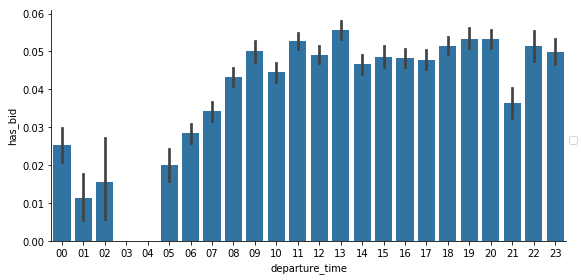

In [227]:
plot_categories( train_df , cat = 'departure_time' , target = 'has_bid' )

In [200]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489513 entries, 0 to 3682
Data columns (total 12 columns):
departure_time      489513 non-null object
fare_class          489513 non-null object
origin              489513 non-null object
destination         489513 non-null object
currency            489513 non-null object
pax                 489513 non-null int64
channel_source      489513 non-null object
device              489513 non-null object
slider_max_usd      489513 non-null int64
slider_min_usd      489513 non-null int64
slider_start_usd    489513 non-null int64
has_bid             489513 non-null bool
dtypes: bool(1), int64(4), object(7)
memory usage: 45.3+ MB


### Prepare the model data 

In [211]:
#we can factorize all values
train_df_without_dummies = train_df.apply(lambda x: pd.factorize(x)[0])

#or we can generate dummies for the categorical
columns = ["origin", "destination", "pax", "currency", "fare_class", "departure_time", "channel_source", "device"]
train_df_with_dummies = train_df
for column in columns:
    train_df_with_dummies = pd.concat([train_df_with_dummies, pd.get_dummies(train_df_with_dummies[column],column)], axis=1)
    
train_df_with_dummies = train_df_with_dummies.drop(columns, axis = 1)    
train_df_with_dummies.head()

slider_max_usd  slider_min_usd  slider_start_usd  has_bid  origin_AAR  \
0            1095             631               767    False           0   
1             486             130               213    False           0   
3             611             246               337    False           0   
4            1441             760               960    False           0   
6             731             357               437    False           0   

   origin_ABZ  origin_ACC  origin_ADB  origin_ADD  origin_ADL      ...        \
0           0           0           0           0           0      ...         
1           0           0           0           0           0      ...         
3           0           0           0           0           0      ...         
4           0           0           0           0           0      ...         
6           0           0           0           0           0      ...         

   departure_time_20  departure_time_21  departure_time_22  departure_time_23  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
6                  0                  0                  0                  0   

   channel_source_MARKETING_PAGE  \
0                              1   
1                              1   
3                              1   
4                              1   
6                              1   

   channel_source_MARKETING_PAGE+DETAILS_RESUBMIT_BUTTON  \
0                                                  0       
1                                                  0       
3                                                  0       
4                                                  0       
6                                                  0       

   channel_source_PRE_TRAVEL_EMAIL  \
0                                0   
1                                0   
3                                0   
4                                0   
6                                0   

   channel_source_PRE_TRAVEL_EMAIL+DETAILS_RESUBMIT_BUTTON  device_desktop  \
0                                                  0                     1   
1                                                  0                     1   
3                                                  0                     1   
4                                                  0                     1   
6                                                  0                     1   

   device_mobile  
0              0  
1              0  
3              0  
4              0  
6              0  

[5 rows x 729 columns]

In [249]:
train_df_with_dummies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 489513 entries, 0 to 3682
Columns: 729 entries, slider_max_usd to device_mobile
dtypes: bool(1), int64(3), uint8(725)
memory usage: 353.9 MB


In [212]:
plot_correlation_map (train_df_without_dummies )